In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.047 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

### Parsing

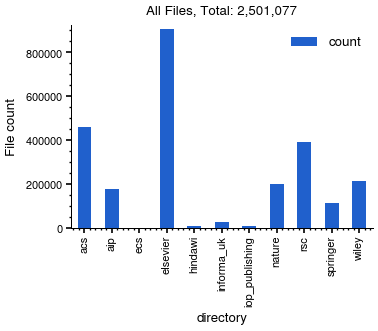

,directory,count
0,acs,457468
1,aip,177932
2,ecs,42
3,elsevier,907234
4,hindawi,6951
5,informa_uk,27900
6,iop_publishing,8007
7,nature,198487
8,rsc,392347
9,springer,111360


In [7]:
df = execute("""
             SELECT directory, count(*) FROM paper_corpus pc
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='File count', title=f"All Files, Total: {total:,}")
plt.savefig('notebooks/files_per_directory.png', dpi=600)
plt.show()
df

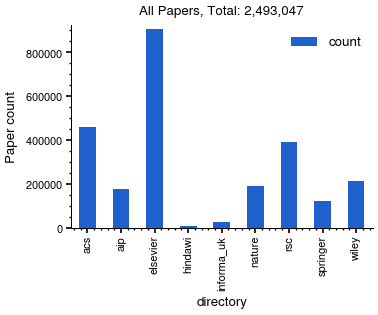

,directory,count
0,acs,457510
1,aip,177932
2,elsevier,907234
3,hindawi,6951
4,informa_uk,27898
5,nature,189039
6,rsc,392346
7,springer,120808
8,wiley,213329


In [8]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"All Papers, Total: {total:,}")
plt.savefig('notebooks/papers_per_directory.png', dpi=600)
plt.show()
df

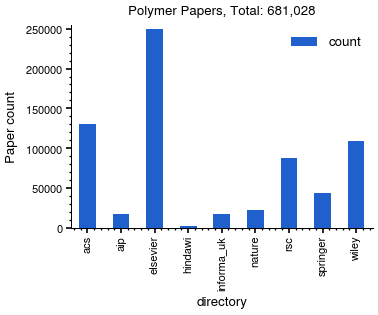

,directory,count
0,acs,130971
1,aip,17070
2,elsevier,250057
3,hindawi,2605
4,informa_uk,17396
5,nature,22208
6,rsc,87429
7,springer,44324
8,wiley,108968


In [9]:
df = execute("""
             SELECT directory, count(*) FROM papers p
             JOIN filtered_papers fp on fp.doi = p.doi
             GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paper count', title=f"Polymer Papers, Total: {total:,}")
plt.savefig('notebooks/polymer_papers_per_directory.png', dpi=600)
plt.show()
df

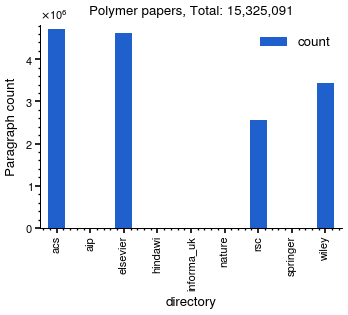

,directory,count
0,acs,4726853
1,aip,4
2,elsevier,4613877
3,hindawi,74
4,informa_uk,24
5,nature,11
6,rsc,2555985
7,springer,63
8,wiley,3428200


In [10]:
df = execute("""
        SELECT directory, count(*) FROM paper_texts pt
        -- only the polymer papers
        JOIN filtered_papers fp ON fp.doi = pt.doi 
        GROUP BY directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Paragraph count', title=f"Polymer papers, Total: {total:,}")
plt.savefig('notebooks/paragraphs_per_directory.png', dpi=600)
plt.show()
df

### Filtering

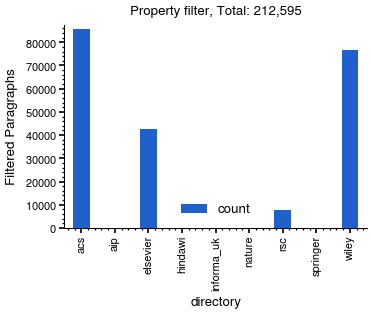

,directory,count
0,acs,85856
1,aip,2
2,elsevier,42547
3,hindawi,3
4,informa_uk,21
5,nature,15
6,rsc,7538
7,springer,75
8,wiley,76538


In [11]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'property_%'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property filter, Total: {total:,}')
plt.savefig('notebooks/property_filtered_para_per_directory.png', dpi=600)
plt.show()
df

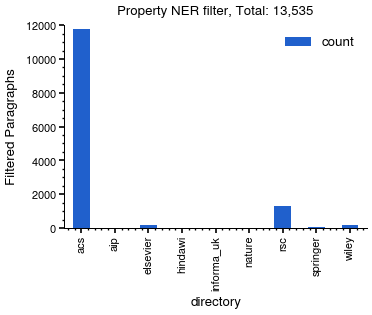

,directory,count
0,acs,11793
1,aip,2
2,elsevier,167
3,hindawi,2
4,informa_uk,19
5,nature,15
6,rsc,1275
7,springer,73
8,wiley,189


In [12]:
df = execute("""
    -- property specific ner filters
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name LIKE 'ner_%'
    AND fp.filter_name != 'ner_filter'
    GROUP BY pt.directory;
""")
total = df['count'].sum()

fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs',
       title = f'Property NER filter, Total: {total:,}')
plt.savefig('notebooks/property_ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

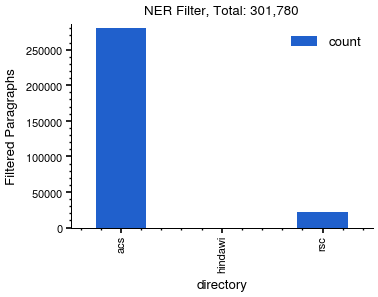

,directory,count
0,acs,280073
1,hindawi,3
2,rsc,21704


In [13]:
df = execute("""
    -- general ner filter
    SELECT pt.directory, count(*) FROM filtered_paragraphs fp
    -- get directory names
    JOIN paper_texts pt ON fp.para_id = pt.id
    WHERE fp.filter_name = 'ner_filter'
    GROUP BY pt.directory;
""")
total = df['count'].sum()
fig, ax = plt.subplots()
df.set_index('directory').plot.bar(ax=ax)
ax.set(ylabel='Filtered Paragraphs', title = f'NER Filter, Total: {total:,}')
plt.savefig('notebooks/ner_filtered_para_per_directory.png', dpi=600)
plt.show()
df

### Extracted Data

In [14]:
# Materials extracted.
execute("select count(*) from extracted_materials")

,count
0,241396


In [15]:
# Properties extracted.
execute("select count(*) from extracted_properties")

,count
0,521189


In [16]:
def extract_properties(property : str):
    df = execute("""
        SELECT pt.doi, em.entity_name AS material, ep.numeric_value, ep.unit
        FROM extracted_properties ep
        -- get material name and class
        JOIN extracted_materials em ON em.id = ep.material_id
        -- get doi
        JOIN paper_texts pt ON pt.id = em.para_id
        -- filter with property coreferents
        WHERE ep.entity_name IN (
            SELECT UNNEST(pm.other_names) FROM property_metadata pm
            WHERE pm.name = :prop_name
        )
        -- value should be within range
        AND ep.numeric_value >= (
            SELECT lower_limit FROM property_metadata
            WHERE name = :prop_name
        )
        AND ep.numeric_value <= (
            SELECT upper_limit FROM property_metadata
            WHERE name = :prop_name
        )
        -- select only polymers
        AND em.material_class LIKE 'POLYMER%';
    """, prop_name=property)
    return df

In [17]:
def unit_counts(df):
    return df.groupby('unit').nunique().numeric_value.sort_values(ascending=False)

In [19]:
def plot_histogram(df, name):
    # Most common unit
    unit = df.groupby('unit').nunique().numeric_value.sort_values(ascending=False).index[0]
    avg = df.numeric_value.mean()
    stdev = df.numeric_value.std()

    fig, ax = plt.subplots()
    df.hist('numeric_value', bins=20, label=f'Total: {df.shape[0]:,}', ax=ax)
    ax.legend()
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    plt.savefig(f'notebooks/hist.{name.replace("/", "_")}.png', dpi=300)
    plt.show()

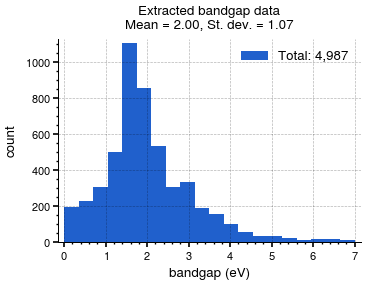

,doi,material,numeric_value,unit
0,10.1021/acs.jpclett.7b02589,BaZr_{1-} xTi xS_{3},1.76,eV
1,10.1021/acs.jpclett.7b02589,BaZr_{1-} xTi xS_{3},1.47,eV
2,10.1021/acs.macromol.8b01946,bis-TBI,1.18,eV
3,10.1021/acs.macromol.8b01946,bis-TBI-1,1.18,eV
4,10.1021/acs.macromol.8b01946,PTBI,1.18,eV
...,...,...,...,...
4982,10.1021/acsami.0c04516,MAPbBr_{3},2.24,eV
4983,10.1021/acsami.0c04516,MAPbBr_{3},2.21,eV
4984,10.1021/acs.jpcc.5b06432,IDM-DHP,2.73,eV
4985,10.1021/acs.jpcc.5b06432,IDM,2.73,eV


In [20]:
df = extract_properties('bandgap')
plot_histogram(df, 'bandgap')
df

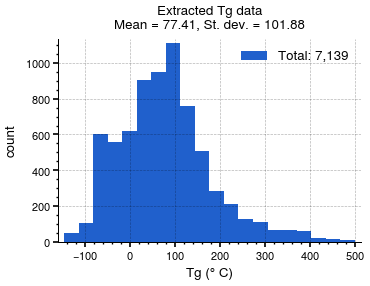

,doi,material,numeric_value,unit
0,10.1021/ma200034u,P,54.0,° C
1,10.1021/ma200034u,AOA,-8.0,° C
2,10.1021/ma200034u,AOA-37-30,-8.0,° C
3,10.1021/ma200034u,O,-44.0,° C
4,10.1021/ma200034u,B,10.0,° C
...,...,...,...,...
7134,10.1021/acs.chemrev.6b00586,P­(S-SOEM-OEM),-54.0,° C
7135,10.1021/acs.chemrev.6b00586,P­(S-OEMS-OEM),-43.0,° C
7136,10.1021/acs.chemrev.6b00586,poly­(styrene-b -oxyethylene methacrylate),-47.0,° C
7137,10.1021/acs.macromol.7b00875,AAm,165.0,° C


In [21]:
df = extract_properties('glass transition temperature')
plot_histogram(df, 'Tg')
df

In [11]:
# Make histograms for all properties.
props = execute("select * from property_metadata")
# for prop in props.name:
#     df = extract_properties(prop)
#     if df is not None:
#         plot_histogram(df, prop)

In [14]:
postgres.disconnect()